<a href="https://colab.research.google.com/github/Ann-Bond-coder/Artificial-intelligence/blob/main/Bondarenko_AI(lab9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import pandas as pd
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, log_loss, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
drive.mount('/content/drive')
original_path = '/content/drive/MyDrive/Colab Notebooks/data/bank2.csv'
data = pd.read_csv(original_path)
print('Розмір датафрейму - ', data.shape)
data.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Розмір датафрейму -  (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
#1. Вивести загальні характеристики набору даних
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [ ]:
#2. Вивести основні статистичні показники набору даних
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [ ]:
#3. перевірити наявність NaN значень (для типу об’єкт вивести
#унікальні значення для кожного такого стовбця, якщо всі значення
#допустимі для цієї ознаки, то рахувати надалі за NaN пустий рядок)
#в кожній ознакі набору (в кожному стовбці датафрейму)

for column in data.columns:
    if data[column].dtype == 'object':
        unique_values = data[column].fillna('').unique()
        print(f"Unique values for column '{column}':")
        print(f"{unique_values}\n")
    else:
        has_nan = data[column].isna().any()
        print(f"Column '{column}' has NaN values: {has_nan}\n")

Column 'age' has NaN values: False

Unique values for column 'job':
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']

Unique values for column 'marital':
['married' 'single' 'divorced']

Unique values for column 'education':
['secondary' 'tertiary' 'primary' 'unknown']

Unique values for column 'default':
['no' 'yes']

Column 'balance' has NaN values: False

Unique values for column 'housing':
['yes' 'no']

Unique values for column 'loan':
['no' 'yes']

Unique values for column 'contact':
['unknown' 'cellular' 'telephone']

Column 'day' has NaN values: False

Unique values for column 'month':
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

Column 'duration' has NaN values: False

Column 'campaign' has NaN values: False

Column 'pdays' has NaN values: False

Column 'previous' has NaN values: False

Unique values for column 'poutcome':
['unknown' 'other' 'failur

In [36]:
#4. Створити власну лямбда – функцію обробку категоріальних значень
#цільової змінної (deposit) у датасеті (значення yes буде 1, no буде 0)
newData = data.copy()
mapping = {'yes': 1, 'no': 0}
newData['deposit'] = data['deposit'].map(lambda x: mapping[x])

newData.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [37]:
#5. Виконати перетворення інших категоріальних стовбців у числові
newData['default'] = data['default'].map(lambda x: mapping[x])
newData['housing'] = data['housing'].map(lambda x: mapping[x])
newData['loan'] = data['loan'].map(lambda x: mapping[x])

newData.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,0,2343,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,0,45,0,0,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,0,1270,1,0,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,0,2476,1,0,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,0,184,0,0,unknown,5,may,673,2,-1,0,unknown,1


no     5873
yes    5289
Name: deposit, dtype: int64


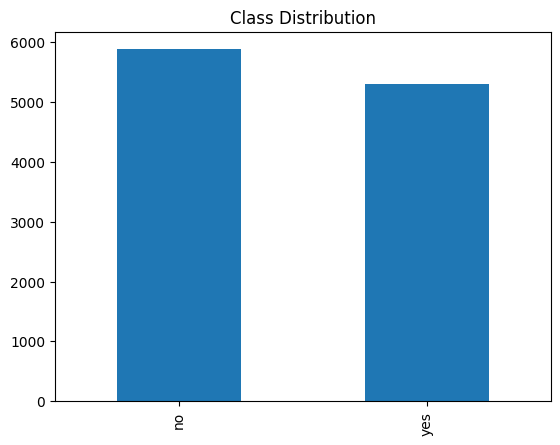

no     9702
yes    1460
Name: loan, dtype: int64


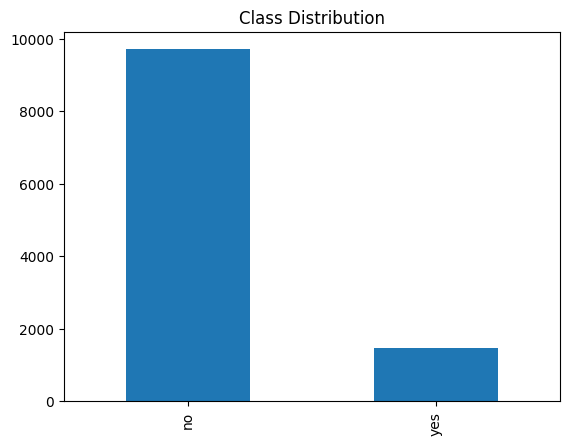

no     5881
yes    5281
Name: housing, dtype: int64


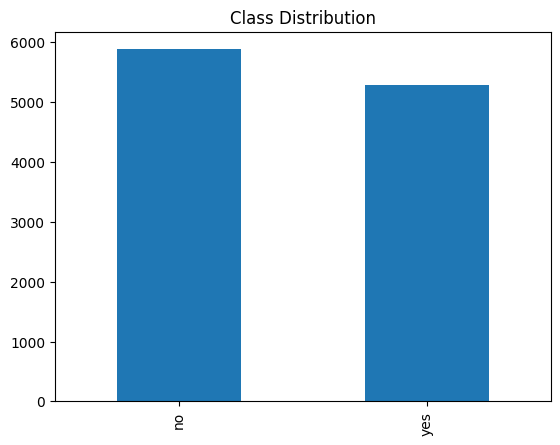

no     10994
yes      168
Name: default, dtype: int64


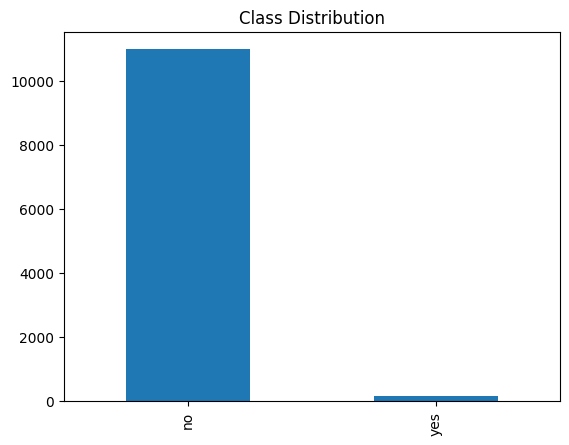

In [ ]:
#6. Розрахувати та виконати візуалізацію розподілу класів у наборі даних
class_counts = data['deposit'].value_counts()
print(class_counts)
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()
class_counts = data['loan'].value_counts()
print(class_counts)
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()
class_counts = data['housing'].value_counts()
print(class_counts)
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()
class_counts = data['default'].value_counts()
print(class_counts)
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()

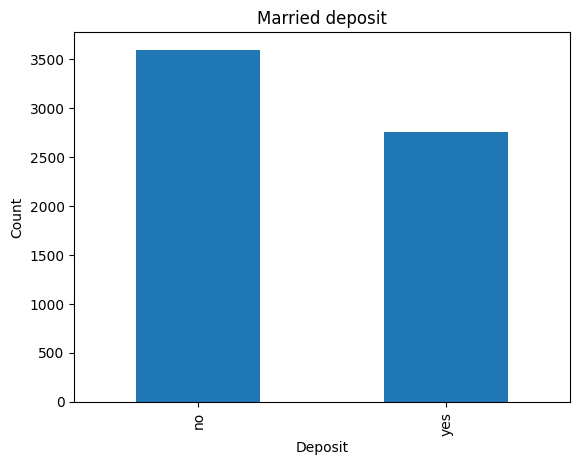

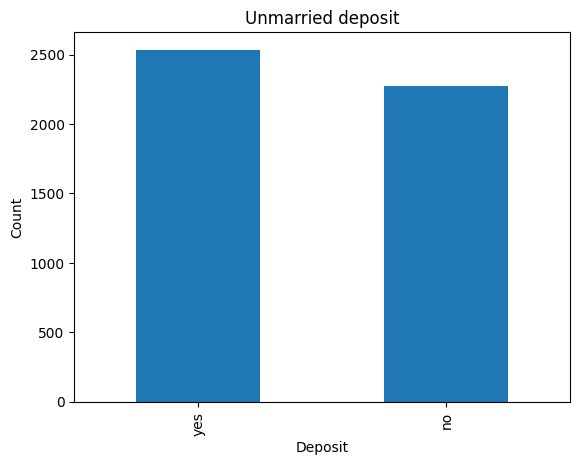

In [ ]:
#7. Виконати візуалізацію, що надає інформацію, скільки з одружених
#мають депозит, а скільки – ні, і так само для неодружених
married_deposit = data[data['marital'] == 'married']['deposit'].value_counts()
single_deposit = data[data['marital'] != 'married']['deposit'].value_counts()

married_deposit.plot(kind='bar', xlabel="Deposit" , ylabel="Count" ,title='Married deposit')
plt.show()
single_deposit.plot(kind='bar', xlabel="Deposit" , ylabel="Count" , title='Unmarried deposit')
plt.show()

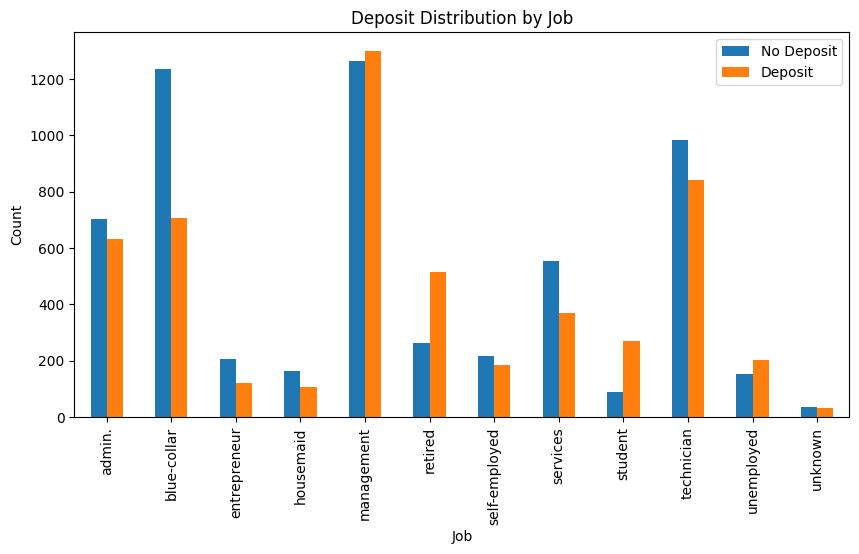

In [ ]:
#8. Виконати візуалізацію, що надає інформацію, скільки клієнтів для
#кожного наявного в датафреймі типу роботи мають депозит, а скільки – ні.
job_deposit = data.groupby(['job', 'deposit']).size().unstack()

fig, ax = plt.subplots(figsize=(10, 5))
width = 0.5

job_deposit.plot(kind='bar', ax=ax)

ax.set_xlabel('Job')
ax.set_ylabel('Count')
ax.set_title('Deposit Distribution by Job')
ax.legend(['No Deposit', 'Deposit'])
plt.show()

In [42]:
newData2 = pd.get_dummies(newData, columns=['job', 'contact', 'marital', 'education', 'month', 'poutcome'])

newData2.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,2343,1,0,5,1042,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,56,0,45,0,0,5,1467,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,41,0,1270,1,0,5,1389,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,55,0,2476,1,0,5,579,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,54,0,184,0,0,5,673,2,-1,0,...,0,0,1,0,0,0,0,0,0,1


In [58]:
#9. Провести стандартизацію всіх незалежних змінних набору, щоб
#значення належали до діапазону від 0 до 1.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(newData2)

print(scaled_data)

[[0.53246753 0.         0.10437133 ... 0.         0.         1.        ]
 [0.49350649 0.         0.07827282 ... 0.         0.         1.        ]
 [0.2987013  0.         0.09218521 ... 0.         0.         1.        ]
 ...
 [0.18181818 0.         0.07809111 ... 0.         0.         1.        ]
 [0.32467532 0.         0.07776175 ... 0.         0.         0.        ]
 [0.20779221 0.         0.07776175 ... 0.         0.         1.        ]]


In [61]:
#10. Провести розподіл датасету на навчальну та тестову множину
x=newData2["deposit"]
y=newData2.iloc[:,:-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=17)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8929,)
(2233,)
(8929, 48)
(2233, 48)


In [65]:
#11. Провести навчання моделі за варіантом алгоритм, що був у ЛР7(варіант 18)
classifier = KNeighborsClassifier()
classifier.fit(y_train, x_train)

KNeighborsClassifier()

In [70]:
#12. Виконати класифікацію тестової частини
x_pred = classifier.predict(y_test)

print(x_pred)

[0 0 0 ... 0 1 1]


In [71]:
#13. Вивести Confusion Matrix
conf_mat = confusion_matrix(x_test, x_pred)

conf_mat

array([[904, 253],
       [307, 769]])

In [73]:
#14. Вивести Classification Report
print(classification_report(x_test, x_pred))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1157
           1       0.75      0.71      0.73      1076

    accuracy                           0.75      2233
   macro avg       0.75      0.75      0.75      2233
weighted avg       0.75      0.75      0.75      2233

